In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, balanced_accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

# Read features

In [2]:
from read_features import *
from threshold_search import *

In [3]:
STATE=42
model_dir = "./ruBert-base-ru-cola_32_0.0001_lr_0.1_decay_balanced/"
data_dir = "./data/ru-cola/"

In [4]:
file_type = ".csv" # .csv or .tsv
train_set_name, valid_set_name, test_set_name = ("train", "dev","test") 
data_args = dict(((k, eval(k)) for k in ("data_dir", "file_type")))
(sents_train, y_train), (sents_valid, y_valid), (sents_test, y_test) = list(map(lambda x_: read_labels(x_, **data_args), 
                                                [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

In [5]:
topological_thr = 6
features_dir = model_dir + "/features/"

In [6]:
kwargs = dict(((k, eval(k)) for k in ("features_dir", "model_dir", "topological_thr")))
X_train, X_valid, X_test = list(map(lambda x_: load_features(x_, **kwargs), [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

Loading test features...: 100%|██████████| 432/432 [00:04<00:00, 86.97it/s] 


In [7]:
# # Exclude weakly connected components equal to b0 Betti number
# X_train = X_train.iloc[:, ~X_train.columns.str.startswith('w')]
# X_valid = X_valid.iloc[:, ~X_valid.columns.str.startswith('w')]
# X_test = X_test.iloc[:, ~X_test.columns.str.startswith("w")]

# Removing constant and quasi-constant features
var_thr = VarianceThreshold(threshold = 0.000001)
var_thr.fit(X_train)
not_constant_f = var_thr.get_support()
X_train = X_train.loc[:, not_constant_f]
X_valid = X_valid.loc[:, not_constant_f]
X_test = X_test.loc[:, not_constant_f]

# Acceptability classification with topological, ripser, template features

In [8]:
def score_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)
score_mcc_ = make_scorer(score_mcc, greater_is_better=True)
# Print summary statistics of the results
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [9]:
# Parameters grid
params = {'tol': 1e-6, 'max_iter': 10000, 'random_state': STATE, 'solver': 'liblinear', "penalty": 'l1'}
N_FEATURES_OPTIONS =  np.arange(50,110,10)
C_OPTIONS = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
CLASS_WEIGHT = [None,'balanced']
params_grid = {'reduce_dim__n_components': N_FEATURES_OPTIONS, 'clf__C': C_OPTIONS, 'clf__class_weight': CLASS_WEIGHT}

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reduce_dim', PCA(whiten=True, random_state=STATE)),
    ('clf', LogisticRegression(**params))])
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=STATE)
clf_pca = GridSearchCV(pipeline, cv=kfold, verbose=4, param_grid=params_grid, 
                       n_jobs=15, scoring=score_mcc_)
start = time()
clf_pca.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf_pca.cv_results_['params'])))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
GridSearchCV took 264.79 seconds for 120 candidate parameter settings.


In [11]:
report(clf_pca.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.948 (std: 0.006)
Parameters: {'clf__C': 0.06, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 90}

Model with rank: 2
Mean validation score: 0.948 (std: 0.005)
Parameters: {'clf__C': 0.09, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 70}

Model with rank: 3
Mean validation score: 0.948 (std: 0.006)
Parameters: {'clf__C': 0.09, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 90}

Model with rank: 4
Mean validation score: 0.947 (std: 0.001)
Parameters: {'clf__C': 0.1, 'clf__class_weight': None, 'reduce_dim__n_components': 60}

Model with rank: 5
Mean validation score: 0.947 (std: 0.005)
Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'reduce_dim__n_components': 70}



In [12]:
# Pipeline with a set of optimal hyperparameters
from sklearn import set_config
set_config(display='diagram')
display(clf_pca.best_estimator_)
pca = clf_pca.best_estimator_.named_steps['reduce_dim']

Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dim',
                 PCA(n_components=90, random_state=42, whiten=True)),
                ('clf',
                 LogisticRegression(C=0.06, class_weight='balanced',
                                    max_iter=10000, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=1e-06))])

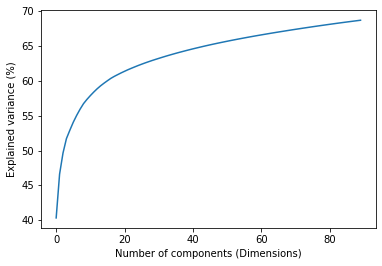

In [13]:
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")
plt.show()

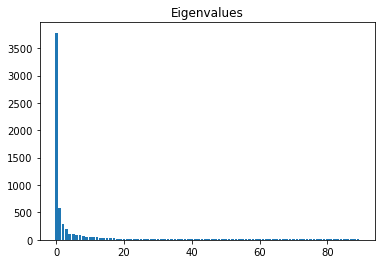

In [14]:
plt.bar(range(pca.n_components), pca.explained_variance_)
plt.title("Eigenvalues")
plt.show()

In [15]:
scl = clf_pca.best_estimator_.named_steps['scaler']
model = clf_pca.best_estimator_.named_steps['clf']
X_scaled_train = scl.transform(X_train.values)
X_pca_train = pca.transform(X_scaled_train)
model.fit(X_pca_train, y_train)

LogisticRegression(C=0.06, class_weight='balanced', max_iter=10000,
                   penalty='l1', random_state=42, solver='liblinear',
                   tol=1e-06)

## PCA pipeline scores

In [16]:
# Pipeline scores maximizing MCC on train set
yhat_train = clf_pca.predict_proba(X_train)[:, 1]
thr_mcc, _, _ = print_thresholds(y_train, yhat_train)
yhat_valid = clf_pca.predict_proba(X_valid)[:, 1]
y_pred_thr_mcc_valid = np.where(yhat_valid >= thr_mcc, 1, 0)
print_scores(y_valid, y_pred_thr_mcc_valid)
yhat_test = clf_pca.predict_proba(X_test)[:, 1]
y_pred_thr_mcc = np.where(yhat_test >= thr_mcc, 1, 0)
print_scores(y_test, y_pred_thr_mcc)

Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.303661940271784
Bal. Acc. =	0.9773891499083125
Accuracy =	0.9819545050196975
MCC score =	0.9526000864570916	

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.5748838504037912
Bal. Acc. =	0.9817751834601763
Accuracy =	0.9801753717117804
MCC score =	0.9490802551827316	

Bal. Acc. =	0.731
Accuracy =	0.801
MCC score =	0.467	

Bal. Acc. =	0.689
Accuracy =	0.737
MCC score =	0.408	



(0.7366962305986696, 0.4076846783518618)

# PCs Shapley values

In [17]:
import shap

In [18]:
import seaborn as sns
cmap = sns.color_palette("mako", as_cmap= True)

In [19]:
excluded = {"Imperative", "Violations"}
def list_grammar_features(df):
    after = 'detailed_source'
    r = []
    take = False
    for c in df.columns:
        if take and c and c not in excluded:
            r.append(c)
        if c == after:
            take = True
    return r
def select_grammar_feature(XXX, yyy, name, cut_size=0):
    phenomena_df = cola_gr_major.copy()
    if cut_size:
        phenomena_df = phenomena_df.iloc[cut_size:, :]
    idx = phenomena_df[name] == 1
    Xf = XXX[idx].copy()
    yf = yyy[idx].copy()
    return idx, Xf, yf

In [20]:
cola_gr_major = pd.read_csv(data_dir + "phenomena.csv", index_col=0)
cola_gr_major = cola_gr_major[cola_gr_major['sentence'].isin(np.concatenate((sents_valid.values,sents_test.values), axis=None))]
cola_gr_major = cola_gr_major.reset_index()

In [21]:
# concatenate dev and test for local Shapley values calculation
XX = pd.concat([X_valid.loc[:, X_train.columns], X_test.loc[:, X_train.columns]], axis = 0).reset_index(drop=True)
yy = np.concatenate((y_valid, y_test), axis = 0)

In [22]:
pca = clf_pca.best_estimator_.named_steps['reduce_dim']
scl = clf_pca.best_estimator_.named_steps['scaler']
model = clf_pca.best_estimator_.named_steps['clf']
X_scaled_train = scl.transform(X_train.values)
X_shap_train = pca.transform(X_scaled_train)
model.fit(X_shap_train, y_train)
X_scaled_test = scl.transform(XX)
X_shap_test = pca.transform(X_scaled_test)
explainer = shap.LinearExplainer(model, X_shap_train)
shap_values = explainer.shap_values(X_shap_test)

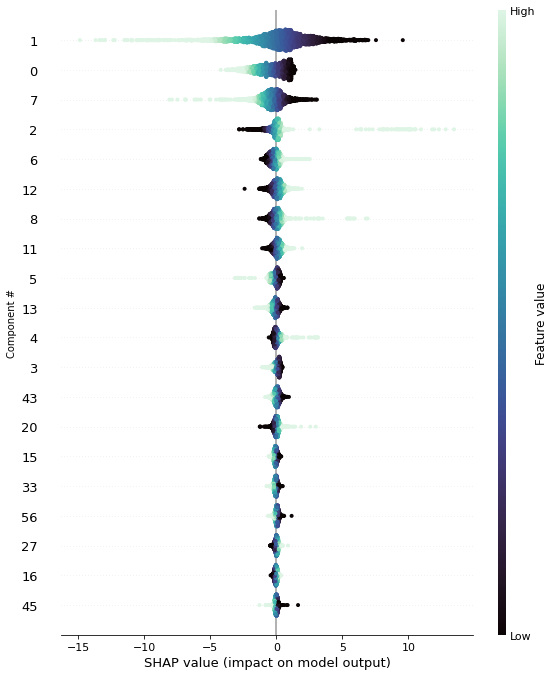

In [23]:
shap.summary_plot(shap_values, X_shap_test, 
                  cmap = cmap, plot_type = "dot", axis_color = "black",
                  show = False,feature_names=[str(i) for i in range(shap_values.shape[1])])
plt.ylabel("Component #")
plt.show()

In [24]:
pca_comp_imp = pd.DataFrame(shap_values)
shapley_important_comp = np.argsort(np.abs(pca_comp_imp.values).mean(0))[-20:][::-1]
mean_pca_scores = pd.DataFrame(data=np.mean(np.abs(shap_values[:,[shapley_important_comp]]), axis = 0).T, index =shapley_important_comp, columns = ["Mean(|SHAP value|)"])
mean_pca_scores.index.name="PC#"
mean_pca_scores

,Mean(|SHAP value|)
PC#,
1,1.951528
0,0.934683
7,0.708084
2,0.470299
6,0.326879
12,0.325682
8,0.310677
11,0.256492
5,0.232557


In [25]:
from collections import defaultdict,Counter

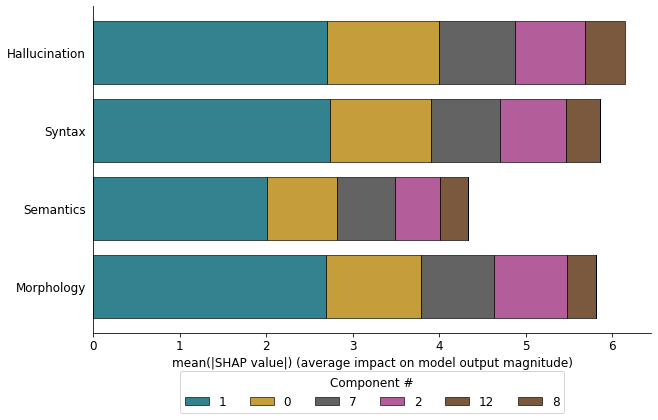

In [26]:
plt.rcParams["figure.figsize"] = (10,6)
cmap = sns.color_palette("dark")[::-1]
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
max_display = 5 # # of important components to show
all_phenomena = list_grammar_features(cola_gr_major)
y_pos = np.arange(len(all_phenomena))
left_pos = np.zeros(len(all_phenomena))
for p,f in enumerate(all_phenomena):
    phenomena_idx, _, _ = select_grammar_feature(XX.values, yy, f)
    feature_order = pd.DataFrame(shap_values[phenomena_idx, :])
    feature_inds = feature_order.loc[:,np.argsort(np.abs(feature_order.values).mean(0))[-max_display:]].columns[::-1].tolist()
    for ind,i in enumerate(feature_inds):
        global_shap_values = np.zeros(len(all_phenomena))
        global_shap_values[p] = np.abs(shap_values[phenomena_idx, i]).mean(0) 
        ax.barh(y_pos, global_shap_values, left=left_pos, align='center',
                color=cmap[ind], label=i, edgecolor = "black", 
                linewidth = 0.8, alpha = 0.8)
        left_pos += global_shap_values
handles, labels = ax.get_legend_handles_labels()
order = Counter(labels)
unique = sorted([(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]], 
                key = lambda x: order[x[-1]],reverse =True)
ax.legend(*zip(*unique),title = "Component #",frameon=True, ncol=len(unique),loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_yticks(y_pos)
plt.gca().set_yticklabels(all_phenomena)
plt.gca().yaxis.set_ticks_position('none')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.show()

In [27]:
def sorted_features(v, X):
    """
    Return data frame with names and values sorted by absolute values in descending order
    Args:
        X (pandas.DataFrame) - input Frame
        v (np.array[int]) - coeffs numpy vector
    """
    idx = list(np.argsort(np.abs(v)))
    idx.reverse()
    df = pd.DataFrame([{'name': X.columns[j], 'idx': j, 'value': v[j]} for j in idx])
    return df

In [28]:
pd.options.display.max_colwidth = None

In [29]:
pca_not_imp = [9,56] # ex of the least important components addition
pca_features = [[f"{i}", ", ".join(sorted_features(pca.components_[i], X_train)["name"].values[:5])] for i in shapley_important_comp.tolist()[:10] + pca_not_imp]
pca_inner_structure = pd.DataFrame(pca_features, columns = ["PC#", "Features"]).set_index("PC#")
pca_inner_structure # first 10 important components + 2 defined insignificant

,Features
PC#,
1,"v_t0.75_11_10, v_t0.5_11_10, v_t0.5_11_11, v_t0.5_11_1, v_t0.75_11_3"
0,"s_t0.5_1_3, s_t0.5_0_0, s_t0.25_3_4, s_t0.5_2_0, s_t0.75_1_7"
7,"v_t0.05_9_2, v_t0.025_8_4, v_t0.025_9_2, v_t0.1_9_2, v_t0.5_9_2"
2,"c_t0.75_7_11, b1_t0.75_7_11, b1_t0.75_7_2, b1_t0.75_7_5, c_t0.75_7_5"
6,"dot_4_4, dot_4_7, dot_3_7, dot_0_8, dot_3_6"
12,"c_t0.1_11_8, v_t0.1_11_8, v_t0.1_11_5, v_t0.1_11_1, v_t0.1_11_3"
8,"comma_9_8, comma_9_1, comma_9_11, comma_9_6, comma_10_8"
11,"v_t0.025_8_10, v_t0.025_5_11, beginning_5_8, m_t0.25_11_6, h0_n_d_l_t0.25_5_3"
5,"dot_9_8, dot_6_9, dot_9_9, dot_8_3, dot_6_6"
